In [51]:
import pandas as pd
from pytrends.request import TrendReq

from functools import reduce

import numpy as np
from matplotlib import pyplot as plt
from pytrends import dailydata
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



### TO CHANGE
Loading the daily data from google trends by choosing the keywords that can be related to covid crisis

In [279]:
# use capture magic to avoid pytrends from printing
%%capture

# Loading google trends data daily
pytrends = TrendReq(hl="en-US", tz=360)

START_YEAR = 2019
START_MONTH = 1
END_YEAR = 2020
END_MONTH = 10
#keywords = ["virus", "crisis"]

keywords = [
    "recession",
    "war",
    "stock market",
    "conflict",
    "terrorism",
    "mortgage",
    "bankrupcy",
    "debt",
    "elections",
    "economy",
    "protest",
    "shooting",
    "food bank",
    "loan",
]


df_list = []
for keyword in keywords:
    df_tmp = dailydata.get_daily_data(
        keyword, START_YEAR, START_MONTH, END_YEAR, END_MONTH, geo="US"
    )
    df_list.append(df_tmp[keyword].to_frame())

df_merged = reduce(
    lambda left, right: pd.merge(left, right, on=["date"], how="outer"), df_list
)

recession:2019-01-01 2019-01-31
recession:2019-02-01 2019-02-28
recession:2019-03-01 2019-03-31
recession:2019-04-01 2019-04-30
recession:2019-05-01 2019-05-31
recession:2019-06-01 2019-06-30
recession:2019-07-01 2019-07-31
recession:2019-08-01 2019-08-31
recession:2019-09-01 2019-09-30
recession:2019-10-01 2019-10-31
recession:2019-11-01 2019-11-30
recession:2019-12-01 2019-12-31
recession:2020-01-01 2020-01-31
recession:2020-02-01 2020-02-29
recession:2020-03-01 2020-03-31
recession:2020-04-01 2020-04-30
recession:2020-05-01 2020-05-31
recession:2020-06-01 2020-06-30
recession:2020-07-01 2020-07-31
recession:2020-08-01 2020-08-31
recession:2020-09-01 2020-09-30
recession:2020-10-01 2020-10-31
war:2019-01-01 2019-01-31
war:2019-02-01 2019-02-28
war:2019-03-01 2019-03-31
war:2019-04-01 2019-04-30
war:2019-05-01 2019-05-31
war:2019-06-01 2019-06-30
war:2019-07-01 2019-07-31
war:2019-08-01 2019-08-31
war:2019-09-01 2019-09-30
war:2019-10-01 2019-10-31
war:2019-11-01 2019-11-30
war:2019-1

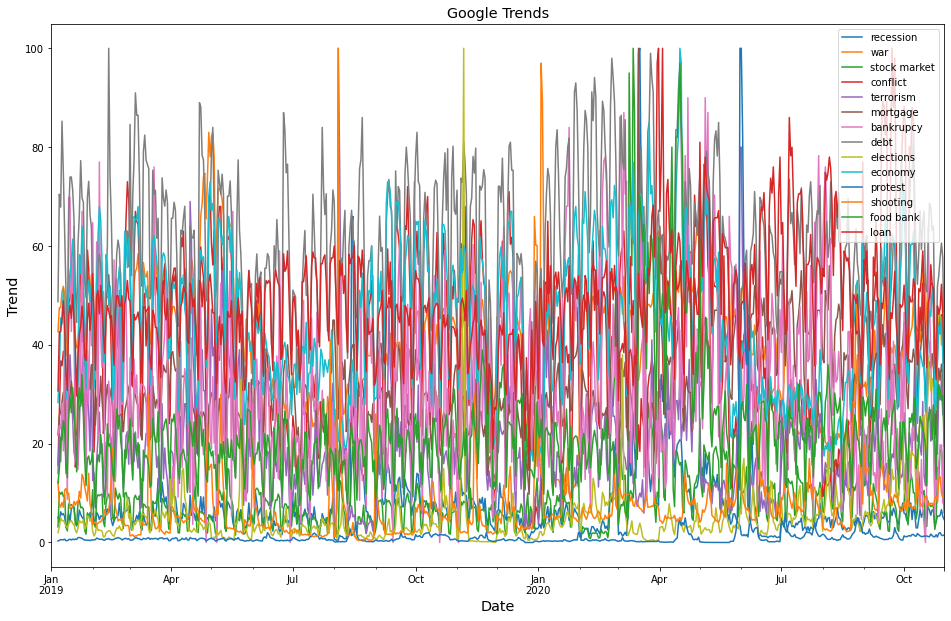

In [31]:
axes=df_merged.plot(figsize=(16,10))
_ = axes.set_xlabel("Date", fontsize="x-large")
_ = axes.set_ylabel("Trend", fontsize="x-large")
_ = axes.set_title("Google Trends", fontsize="x-large")

### Loading daily VIX data from yahoo using the API

In [34]:
vix_obj = yf.Ticker("^VIX")
df_market = vix_obj.history(period="max")
df_market = df_market["Close"].to_frame()
df_market.rename(columns={"Close": "VIX"}, inplace=True)

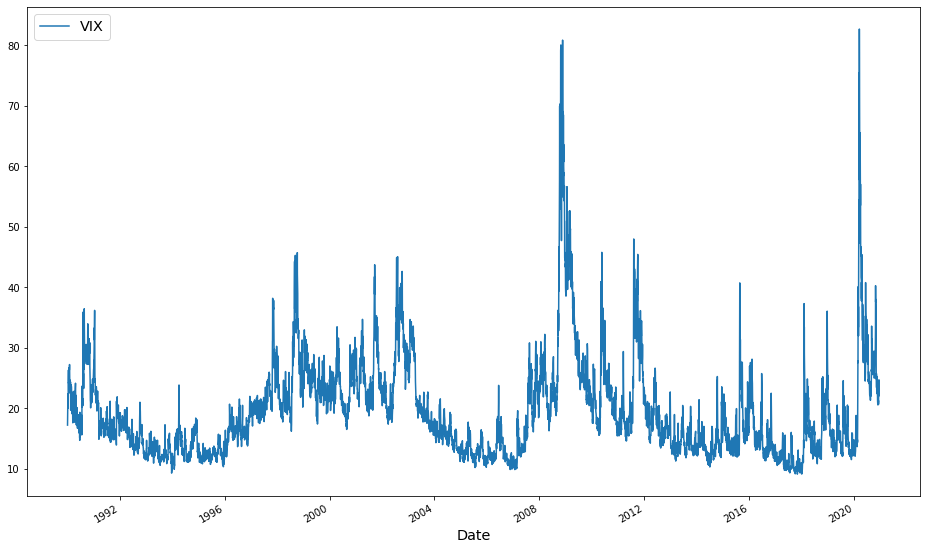

In [35]:
axes = df_market.plot(figsize=(16,10))
_ = axes.set_xlabel("Date", fontsize="x-large")
_ = plt.legend(fontsize="x-large")
keywords = ["stock market", "mortgage", "bankrupcy", "loan"]
# keywords=['recession',
#           'war',
#           'stock market',
#           'conflict',
#           'terrorism',
#           'mortgage',
#           'bankrupcy',
#           'debt',
#           'elections',
#           'economy',
#           'protest',
#           'shooting',
#           'food bank',
#           'loan']

As we have access to the daily data, let us merge both dataframes.
# TO DO: check Nan when merging and understand why

In [37]:
# df_vix['VIX_stat']=np.log(df_vix['VIX'])-np.log(df_vix['VIX'].shift(1))
df_trends = df_merged

df_market = pd.merge(
    df_market, df_trends, how="left", left_index=True, right_index=True
)
# df_vix=np.abs(df_vix-df_vix.shift(1))
# df_vix[keywords]=df_vix[keywords].rolling(20).mean()

df_market.dropna(inplace=True)
df_market.index = pd.to_datetime(df_market.index)
df_market = df_market[["VIX"] + keywords]
df_market.index = pd.to_datetime(df_market.index)

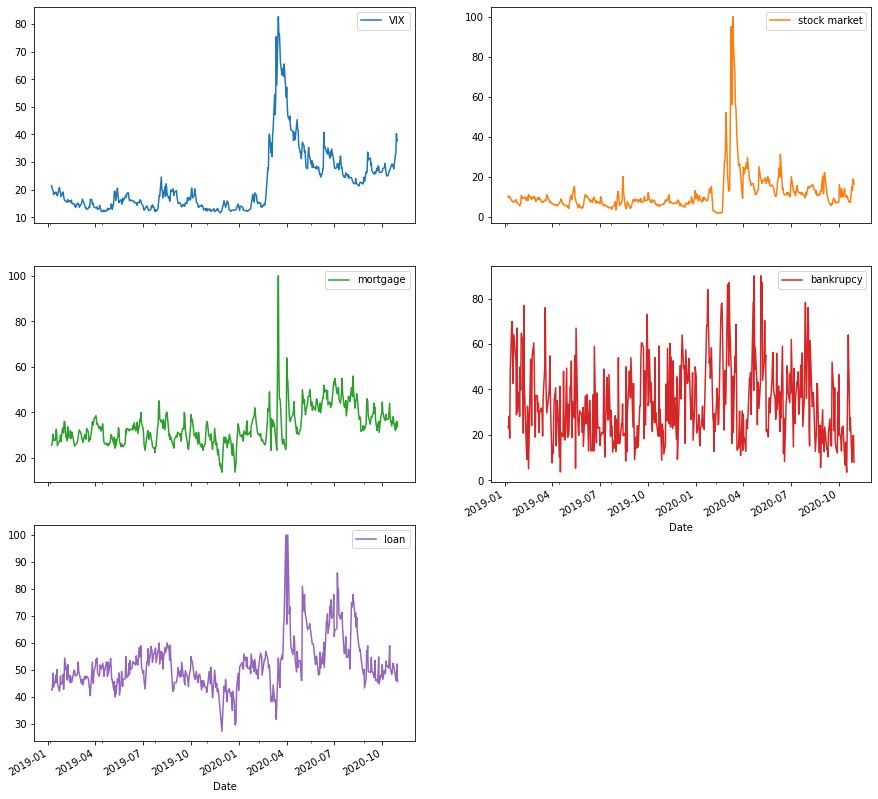

In [40]:
axs = df_market.plot(subplots=True, layout=(3, 2), figsize=(15, 15))

AS we can see above, daily VIX data contains a lot of noise due to trading. Hence it is hard to predict daily changes of the VIX. Furthermore daily google Trends data is also noisy since searches of keywords depend on various factors (workdays/weekends as markets are closed on the weekend). In order to mitigate this noise we are going to resample the data weekly.
For VIX we will be taking the last value of the week as we are interested in predicting the changes, and taking the weekly mean for trends data to reduce the noise

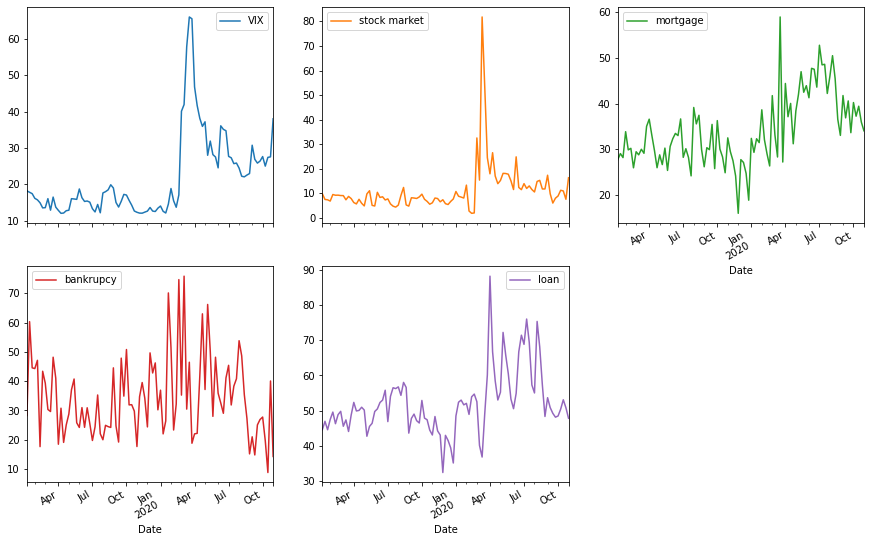

In [41]:
df_vix = df_market["VIX"].resample("1W").last().to_frame()
df_vix[keywords] = df_market[keywords].resample("1W").mean()
_ = df_vix.plot(subplots=True, layout=(3, 3), figsize=(15, 15))

The data is less noisy after resampling and to apply timeseries theory we have to check for stationarity. It is obvious that the timeseries are not stationary (tests below). We are going to calculate the difference and test the stationarity.

In [44]:
column_names = df_vix.columns
ADF_pvalues = [
    adfuller(df_vix[column_name], regression="nc")[1] for column_name in column_names
]
# putting the p-values in a df for pretty printing
df_pvalues = pd.DataFrame(
    list(zip(column_names, ADF_pvalues)), columns=["Indicators", "pvalue"]
)
df_pvalues.round(4)

,Indicators,pvalue
0,VIX,0.5979
1,stock market,0.0280
2,mortgage,0.6546
3,bankrupcy,0.3351
4,loan,0.6083


In [45]:
# Making the timeseries stationary by log difference (most used by practionners)
df_vix = df_vix - df_vix.shift(1)
df_vix.dropna(inplace=True)

column_names = df_vix.columns
ADF_pvalues = [
    adfuller(df_vix[column_name], regression="nc")[1] for column_name in column_names
]
df_pvalues = pd.DataFrame(
    list(zip(column_names, ADF_pvalues)), columns=["Indicators", "pvalue"]
)
df_pvalues.round(5)
df_all_saved = df_vix.copy()

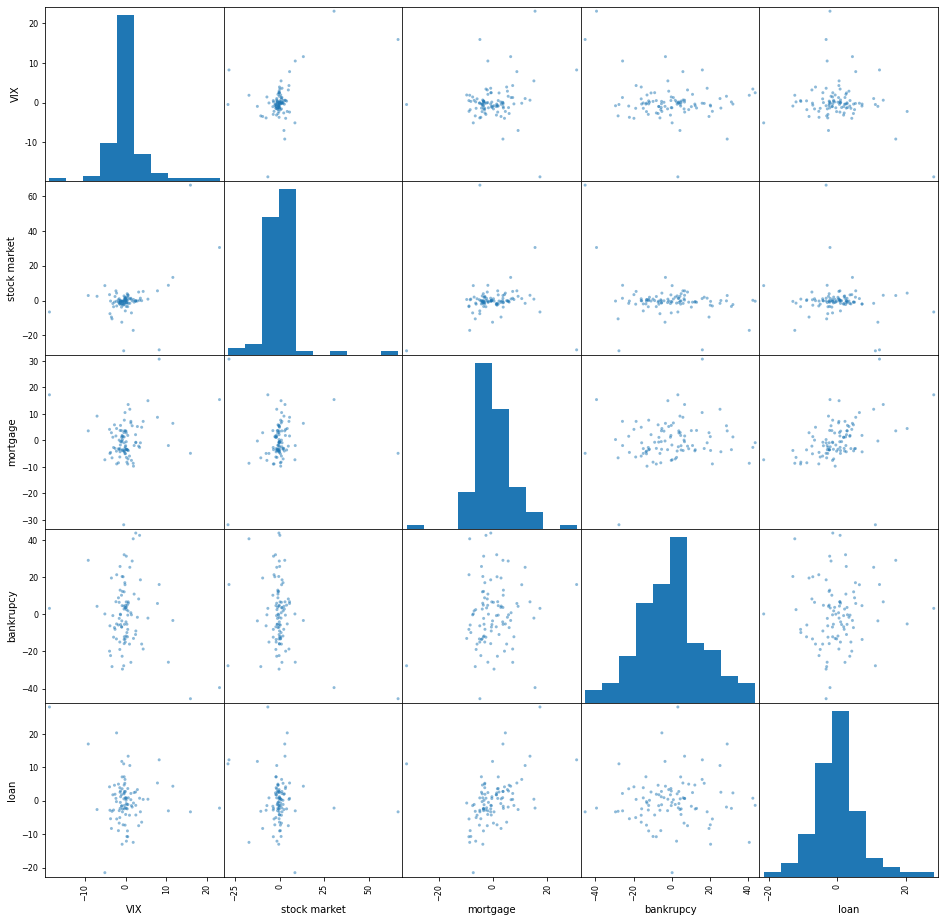

In [50]:
_=pd.plotting.scatter_matrix(df_vix, figsize=(16, 16))

The difference successfuly results to stationary timeseries as the pvalues are almost 0

## Overall model

#### add some text here

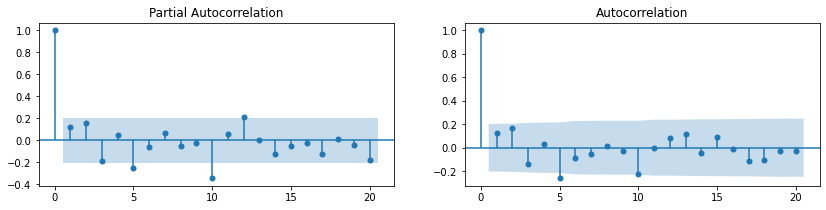

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(14, 3))

plot_pacf(df_vix["VIX"], lags=20, ax=axs[0])
plot_acf(df_vix["VIX"], lags=20, ax=axs[1])
plt.show()

### As we can see from the ACF and PACF, the correlations seems are not statistically significant as the confidence interval is large. Which is normal as we are calculating correlations around a crisis. Let us build an ARMA model using only VIX data to have a baseline to compare when adding Trends data

In [572]:
from statsmodels.tsa.arima.model import ARIMA

model_arma_endo = ARIMA(endog=df_vix["VIX"], order=(2, 0, 2)).fit()
model_arma_endo.summary()
# (2,0,2) seems to be the best model as all values are statiscally significant, implement gridsearch

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    VIX   No. Observations:                   94
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -270.665
Date:                Thu, 17 Dec 2020   AIC                            553.330
Time:                        12:19:06   BIC                            568.590
Sample:                    01-20-2019   HQIC                           559.494
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2254      0.675      0.334      0.739      -1.098       1.549
ar.L1         -1.2115      0.219     -5.530      0.000      -1.641      -0.782
ar.L2         -0.4739      0.217     -2.186      0.029      -0.899      -0.049
ma.L1          1.3990      0.184      7.590      0.000       1.038       1.760
ma.L2          0.7801      0.174      4.487      0.000       0.439       1.121
sigma2        18.4301      1.902      9.691      0.000      14.703      22.157
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               210.45
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               4.53   Skew:                             1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

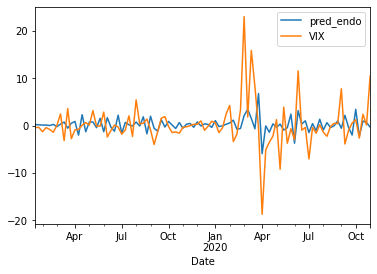

In [573]:
predictions_endo = model_arma_endo.predict()
df_vix["pred_endo"] = predictions_endo
df_vix[["pred_endo", "VIX"]].plot()

### All predictions are insample and we can see that the model is struggling to predict big jumps. It is expected as VIX reacts brutally and considering past values will give us poor predictions.

### Let us add Trends data using a multidimensional VAR model. Below using AIC or BIC we are going to select the order of the VAR model overall

<AxesSubplot:xlabel='VAR order'>

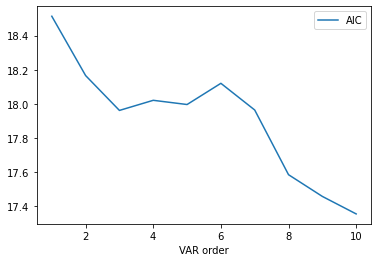

In [574]:
from statsmodels.tsa.api import VAR

model = VAR(df_vix[["VIX"] + keywords])

VAR_orders = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
aic_values = [model.fit(i).aic for i in VAR_orders]
df_aic_values = pd.DataFrame(
    list(zip(VAR_orders, aic_values)), columns=["VAR order", "AIC"]
)
df_aic_values.set_index("VAR order", inplace=True, drop=True)
df_aic_values.plot()

### In order to avoid overfitting we are going to choose the first minimum which is 3. Hence the Var order we are going to choose is 3

In [575]:
selected_VAR_order = 3
model = VAR(df_vix[["VIX"] + keywords])
result = model.fit(selected_VAR_order)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 17, Dec, 2020
Time:                     12:19:11
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    20.1692
Nobs:                     91.0000    HQIC:                   18.8523
Log likelihood:          -1382.88    FPE:                6.43769e+07
AIC:                      17.9618    Det(Omega_mle):     2.86430e+07
--------------------------------------------------------------------
Results for equation VIX
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.205884         0.411226            0.501           0.617
L1.VIX                 -0.070297         0.151276           -0.465           0.642
L1.stock market         0.244423         0.073917     

<AxesSubplot:xlabel='Date'>

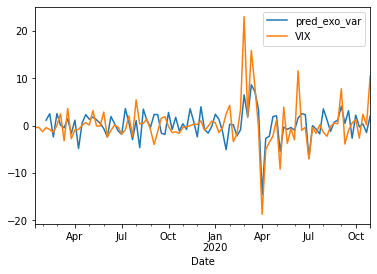

In [576]:
predictions_exo = result.fittedvalues["VIX"]
df_vix["pred_exo_var"] = predictions_exo
df_vix[["pred_exo_var", "VIX"]].plot()

### to stay consistent with the basemodel we developped a VARMA mode (2,2) that will enable us to compare them

In [577]:
from statsmodels.tsa.api import VARMAX

model = VARMAX(df_vix[["VIX"] + keywords], order=(2, 2))
result_varma = model.fit(maxiter=1000, disp=False)
result_varma.summary()

Dep. Variable:,"['VIX', 'stock market', 'mortgage', 'bankrupcy', 'loan']",No. Observations:,94
Model:,"VARMA(2,2)",Log Likelihood,-1406.634
,+ intercept,AIC,3053.268
Date:,"Thu, 17 Dec 2020",BIC,3358.463
Time:,12:19:36,HQIC,3176.545
Sample:,01-20-2019,,
,- 11-01-2020,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.03, 0.00, 0.33, 0.06, 0.46",Jarque-Bera (JB):,"154.76, 52.27, 0.12, 3.27, 1.26"
Prob(Q):,"0.86, 0.98, 0.57, 0.81, 0.50",Prob(JB):,"0.00, 0.00, 0.94, 0.20, 0.53"
Heteroskedasticity (H):,"2.74, 1.92, 0.74, 1.35, 2.47",Skew:,"1.58, 0.78, -0.09, 0.19, 0.25"


<AxesSubplot:xlabel='Date'>

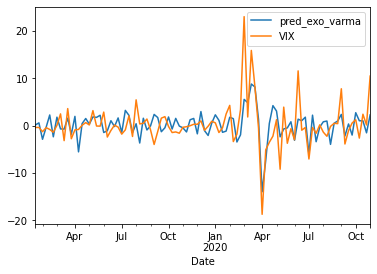

In [578]:
predictions_exo = result_varma.fittedvalues["VIX"]
df_vix["pred_exo_varma"] = predictions_exo
df_vix[["pred_exo_varma", "VIX"]].plot()

In [579]:
print(np.mean(np.abs(df_vix["pred_endo"] - df_vix["VIX"])))
print(np.mean(np.abs(df_vix["pred_exo_var"] - df_vix["VIX"])))
print(np.mean(np.abs(df_vix["pred_exo_varma"] - df_vix["VIX"])))

2.702573704329217
2.5880012253588527
2.531362119924369


### using VARMA with google trends seems to react better expacially in big jumps, but we are doing predictions insample!
### Let us roll the model as an outsample prediction for the 3 models developped
### baseline: AR
### Trends model 1: VAR
### Trends model 2: VARMA

In [597]:
# Helper functions for the ARIMA models

import dask
from tqdm import tqdm

dask.config.set(scheduler="processes")


@dask.delayed
def compute_ARIMA_endo_pred(df, order, index_insample, rolling_window):
    df_training = df.iloc[0:index_insample]
    #     df_training=df.iloc[index_insample-rolling_window:index_insample]
    outsample = df.iloc[index_insample]

    result_fit = ARIMA(endog=df_training["VIX"], order=order).fit()
    result_pred = result_fit.predict(
        start=len(df_training), end=len(df_training)
    ).values[0]
    return result_pred


@dask.delayed
def compute_ARIMA_exo_pred(
    df, order, exogenous_regressors, index_insample, rolling_window
):
    #     df_training=df.iloc[index_insample-rolling_window:index_insample]
    df_training = df.iloc[0:index_insample]
    outsample = df.iloc[index_insample]

    result_fit = ARIMA(
        endog=df_training["VIX"], order=order, exog=df_training[exogenous_regressors]
    ).fit()
    result_pred = result_fit.predict(
        start=len(df_training),
        end=len(df_training),
        exog=list(outsample[exogenous_regressors]),
    ).values[0]
    return result_pred


@dask.delayed
def compute_VAR_exo_pred(
    df, order, exogenous_regressors, index_insample, rolling_window
):
    #     df_training=df.iloc[index_insample-rolling_window:index_insample]
    df_training = df.iloc[0:index_insample]
    outsample = df.iloc[index_insample]
    try:
        result_fit = VAR(df_training).fit(order)
        result_pred = result_fit.forecast(y=df_training.values[-order:], steps=1)[0][0]
    except:
        result_pred = np.nan
    return result_pred


@dask.delayed
def compute_VARMA_exo_pred(
    df, order, exogenous_regressors, index_insample, rolling_window
):
    #     df_training=df.iloc[index_insample-rolling_window:index_insample]
    df_training = df.iloc[0:index_insample]
    outsample = df.iloc[index_insample]
    result_fit = VARMAX(df_training, order=order).fit(maxiter=1000, disp=False)
    result_pred = result_fit.predict(
        start=len(df_training), end=len(df_training)
    ).values[0][0]
    return result_pred


def rolling_ARMA_endo(df, start_window, rolling_window, order=(4, 0, 3)):
    #     df['pred_rolling_endo']=np.nan
    result = []
    all_results_dask = [
        compute_ARIMA_endo_pred(df, order, index_insample, rolling_window)
        for index_insample in np.arange(start_window, len(df))
    ]
    all_results = dask.compute(all_results_dask)

    return all_results


def rolling_ARMA_exo(
    df, start_window, rolling_window, order=(4, 0, 3), exogenous_regressors=["crisis"]
):
    #     df['pred_rolling_endo']=np.nan
    result = []
    all_results_dask = [
        compute_ARIMA_exo_pred(
            df, order, exogenous_regressors, index_insample, rolling_window
        )
        for index_insample in np.arange(start_window, len(df))
    ]
    all_results = dask.compute(all_results_dask)

    return all_results


def rolling_VAR_exo(
    df, start_window, rolling_window, order=4, exogenous_regressors=["crisis"]
):
    #     df['pred_rolling_endo']=np.nan
    result = []
    all_results_dask = [
        compute_VAR_exo_pred(
            df, order, exogenous_regressors, index_insample, rolling_window
        )
        for index_insample in np.arange(start_window, len(df))
    ]
    all_results = dask.compute(all_results_dask)

    return all_results


def rolling_VARMA_exo(
    df, start_window, rolling_window, order=4, exogenous_regressors=["crisis"]
):
    #     df['pred_rolling_endo']=np.nan
    result = []
    all_results_dask = [
        compute_VARMA_exo_pred(
            df, order, exogenous_regressors, index_insample, rolling_window
        )
        for index_insample in np.arange(start_window, len(df))
    ]
    all_results = dask.compute(all_results_dask)

    return all_results

In [598]:
import warnings

warnings.filterwarnings("ignore")
start_rolling = 20
window_rolling = 20
pred_list_endo = rolling_ARMA_endo(
    df_vix, start_rolling, window_rolling, order=(2, 0, 2)
)
pred_list_exo_var = rolling_VAR_exo(
    df_vix[["VIX"] + keywords],
    start_rolling,
    window_rolling,
    order=3,
    exogenous_regressors=keywords,
)
pred_list_exo_varma = rolling_VARMA_exo(
    df_vix[["VIX"] + keywords],
    start_rolling,
    window_rolling,
    order=(2, 2),
    exogenous_regressors=keywords,
)

In [599]:
df_vix["pred_rolling_endo"] = np.nan
df_vix.iloc[start_rolling : len(df_vix)]["pred_rolling_endo"] = pred_list_endo[0]

df_vix["pred_rolling_exo_var"] = np.nan
df_vix.iloc[start_rolling : len(df_vix)]["pred_rolling_exo_var"] = pred_list_exo_var[0]

df_vix["pred_rolling_exo_varma"] = np.nan
df_vix.iloc[start_rolling : len(df_vix)][
    "pred_rolling_exo_varma"
] = pred_list_exo_varma[0]

## change MAE name 

In [600]:
from sklearn.metrics import mean_absolute_error

df_final = df_vix
df_final.dropna(inplace=True)
baseline_mae = mean_absolute_error(df_final["VIX"], df_final["pred_rolling_endo"])
trends_mae_var = mean_absolute_error(df_final["VIX"], df_final["pred_rolling_exo_var"])
trends_mae_varma = mean_absolute_error(
    df_final["VIX"], df_final["pred_rolling_exo_varma"]
)

improvement_var = (baseline_mae - trends_mae_var) / baseline_mae
improvement_varma = (baseline_mae - trends_mae_varma) / baseline_mae


print(f"MAE of the baseline model: {baseline_mae*100:.2f}%")
print(f"MAE of the trends model VAR: {trends_mae_var*100:.2f}%")
print(f"MAE of the trends model VARMA: {trends_mae_varma*100:.2f}%")

print(f"MAE improvement VAR : {improvement_var*100:.2f}%")
print(f"MAE improvement VARMA : {improvement_varma*100:.2f}%")

MAE of the baseline model: 332.19%
MAE of the trends model VAR: 517.71%
MAE of the trends model VARMA: 459.81%
MAE improvement VAR : -55.85%
MAE improvement VARMA : -38.41%


We can see that adding google trends results lowers the performance of outsample predictions. Our hypothesis is that the market contains much more information and reacts way before people start looking for keywords. Let us in the following have an approach used by practionner: create an indicator through machine learning and use this indicator as an Exogeneous variable

In [601]:
print(np.mean(np.abs(df_final["VIX"] - df_final["pred_rolling_endo"])))
print(np.mean(np.abs(df_final["VIX"] - df_final["pred_rolling_exo_var"])))
print(np.mean(np.abs(df_final["VIX"] - df_final["pred_rolling_exo_varma"])))

3.321943464220376
5.177083957149805
4.5980505575069035


In [53]:
df_vix.iloc[len(df_vix) - 200 : len(df_vix)][
    ["VIX", "pred_rolling_endo", "pred_rolling_exo_varma"]
].plot(figsize=(16, 10))

KeyError: "['pred_rolling_endo', 'pred_rolling_exo_varma'] not in index"

### ML approach creating and indicator

In [4]:
%% capture
# Loading google trends data daily
start_year = 2019
start_month = 1
end_year = 2020
end_month = 10
keywords = ["virus", "crisis"]

keywords = [
    "recession",
    "war",
    "stock market",
    "conflict",
    "terrorism",
    "mortgage",
    "bankrupcy",
    "debt",
    "elections",
    "economy",
    "protest",
    "shooting",
    "food bank",
    "loan",
]


df_list = []
for keyword in keywords:
    df_tmp = dailydata.get_daily_data(
        keyword, start_year, start_month, end_year, end_month, geo="US"
    )
    df_list.append(df_tmp[keyword].to_frame())

df_merged = reduce(
    lambda left, right: pd.merge(left, right, on=["date"], how="outer"), df_list
)

recession:2019-01-01 2019-01-31
recession:2019-02-01 2019-02-28
recession:2019-03-01 2019-03-31
recession:2019-04-01 2019-04-30
recession:2019-05-01 2019-05-31
recession:2019-06-01 2019-06-30
recession:2019-07-01 2019-07-31
recession:2019-08-01 2019-08-31
recession:2019-09-01 2019-09-30
recession:2019-10-01 2019-10-31
recession:2019-11-01 2019-11-30
recession:2019-12-01 2019-12-31
recession:2020-01-01 2020-01-31
recession:2020-02-01 2020-02-29
recession:2020-03-01 2020-03-31
recession:2020-04-01 2020-04-30
recession:2020-05-01 2020-05-31
recession:2020-06-01 2020-06-30
recession:2020-07-01 2020-07-31
recession:2020-08-01 2020-08-31
recession:2020-09-01 2020-09-30
recession:2020-10-01 2020-10-31
war:2019-01-01 2019-01-31
war:2019-02-01 2019-02-28
war:2019-03-01 2019-03-31
war:2019-04-01 2019-04-30
war:2019-05-01 2019-05-31
war:2019-06-01 2019-06-30
war:2019-07-01 2019-07-31
war:2019-08-01 2019-08-31
war:2019-09-01 2019-09-30
war:2019-10-01 2019-10-31
war:2019-11-01 2019-11-30
war:2019-1

In [7]:
import yfinance as yf

vix_obj = yf.Ticker("^VIX")
df_market = vix_obj.history(period="max")
df_market = df_market["Close"].to_frame()
df_market.rename(columns={"Close": "VIX"}, inplace=True)

In [8]:
df_trends = df_merged

df_market = pd.merge(
    df_market, df_trends, how="left", left_index=True, right_index=True
)
# df_vix=np.abs(df_vix-df_vix.shift(1))
# df_vix[keywords]=df_vix[keywords].rolling(20).mean()

df_market.dropna(inplace=True)
df_market.index = pd.to_datetime(df_market.index)
df_market = df_market[["VIX"] + keywords]
df_market.index = pd.to_datetime(df_market.index)

In [9]:
df_vix = df_market["VIX"].resample("1W").last().to_frame()
df_vix[keywords] = df_market[keywords].resample("1W").mean()
df_vix = df_vix - df_vix.shift(1)
df_all_saved = df_vix.copy()

In [10]:
df_ml = df_all_saved.copy()

# be sure to rerun above so that keywords are these ones, to change absolutely
keywords = [
    "recession",
    "war",
    "stock market",
    "conflict",
    "terrorism",
    "mortgage",
    "bankrupcy",
    "debt",
    "elections",
    "economy",
    "protest",
    "shooting",
    "food bank",
    "loan",
]


for i in np.arange(1, 5, 1):
    new_cols = [keyword + "_" + str(i) for keyword in keywords]
    df_ml[new_cols] = df_ml[keywords].shift(i)

df_ml.drop(keywords, axis=1, inplace=True)
df_ml.dropna(inplace=True)
df_ml

# df_ml[keywords]=df_ml[keywords].shift(1)
# df_ml.dropna(inplace=True)

,VIX,recession_1,war_1,stock market_1,conflict_1,terrorism_1,mortgage_1,bankrupcy_1,debt_1,elections_1,...,terrorism_4,mortgage_4,bankrupcy_4,debt_4,elections_4,economy_4,protest_4,shooting_4,food bank_4,loan_4
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-17,-0.810000,-0.028,-1.630,2.6620,3.7500,-4.754,-3.988,2.8200,-10.068,-1.764,...,6.128,1.3280,32.046,-2.034,-0.2100,11.620,0.0460,-0.2980,6.9440,2.3640
2019-02-24,-1.400000,0.784,-1.220,-0.2860,-6.1300,-0.640,0.340,-29.4780,16.460,-0.526,...,3.800,-0.8800,-15.779,0.384,0.2975,3.356,0.2545,3.6720,1.8890,-2.3900
2019-03-03,0.059999,-0.272,-0.564,0.0275,-4.4935,15.605,-4.272,25.7415,-12.575,0.775,...,-7.066,5.6800,-0.251,-6.552,0.1525,-7.770,-0.3865,-3.4580,-12.5650,2.9300
2019-03-10,2.480000,0.398,9.636,-0.1595,21.7495,-15.029,3.524,-4.0835,6.435,3.609,...,-4.754,-3.9880,2.820,-10.068,-1.7640,10.298,0.2620,-3.9840,0.9000,2.0880
2019-03-17,-3.169999,-1.332,-3.670,-0.0220,-3.2200,-2.184,-0.680,-8.9680,18.732,-2.382,...,-0.640,0.3400,-29.478,16.460,-0.5260,-8.448,-0.0460,3.8720,1.0500,-3.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-04,1.250000,0.758,-8.202,1.9840,0.2760,0.880,-6.970,1.8400,1.050,5.590,...,-12.386,8.7400,5.832,0.460,1.0920,0.374,-1.5460,-15.8960,5.7840,5.3300
2020-10-11,-2.629999,0.464,-0.720,0.8960,-6.3400,1.576,6.610,0.8400,13.040,2.186,...,11.800,-4.8955,-6.195,-8.728,-0.0480,-3.172,-0.7165,-7.1475,-1.6415,-2.8175
2020-10-18,2.410000,0.016,5.744,2.3260,-2.4920,6.752,-2.992,-8.0740,5.930,2.844,...,-12.174,3.7175,10.259,4.710,1.6500,13.748,-0.4875,5.9015,-2.8605,-1.6245


In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import (
    GridSearchCV,
    LeaveOneOut,
    TimeSeriesSplit,
    cross_val_predict,
)

In [16]:
RANDOM_SEED = 27
X, y = df_ml.drop("VIX", axis=1), df_ml["VIX"]
grid_params = {
    "n_estimators": [50, 100, 150, 300, ],
    "learning_rate": [0.1, 0.01],
    "max_depth": [3, 5],
}
regressor = GradientBoostingRegressor(random_state=RANDOM_SEED)
clf = GridSearchCV(
    estimator=regressor,
    param_grid=grid_params,
    cv=TimeSeriesSplit(5),
    n_jobs=-1,
    verbose=2,
)
clf.fit(X, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.6s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=GradientBoostingRegressor(random_state=27), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 5],
                         'n_estimators': [50, 100, 150, 300]},
             verbose=2)

In [17]:
clf.best_estimator_

GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=50,
                          random_state=27)

In [23]:
vix_estimate_for_anas_miboune = cross_val_predict(
    estimator=clf.best_estimator_, X=X, y=y, cv=LeaveOneOut()
)

<AxesSubplot:xlabel='Date'>

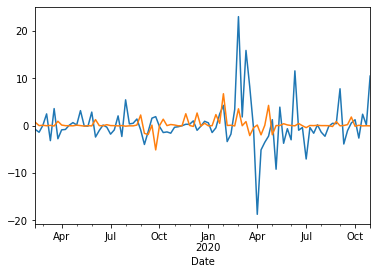

In [27]:
df_ml["pred_indicator"] = vix_estimate_for_anas_miboune
df_ml["VIX"].plot()
df_ml["pred_indicator"].plot()

## Do we stll need what's below ?

In [636]:
index_sep = int(len(df_ml) * 0.5)
df_ml_training = df_ml.iloc[0:]
df_ml_test = df_ml.iloc[index_sep : len(df_ml)]

X_training = df_ml_training.drop(["VIX"], axis=1)
X_training = (X_training - X_training.mean()) / X_training.std()
Y_training = df_ml_training["VIX"]

X_test = df_ml_test.drop(["VIX"], axis=1)
Y_test = df_ml_test["VIX"]

In [646]:
from sklearn.decomposition import PCA

n_components = 18
pca_indicator = PCA(n_components=n_components)
principalComponents_indicator = pca_indicator.fit_transform(X_training)
principal_df = pd.DataFrame(
    data=principalComponents_indicator,
    columns=["principal_" + str(i) for i in np.arange(1, n_components + 1)],
)
principal_df.index = Y_training.index
print(
    "Explained variation per principal component: {}".format(
        pca_indicator.explained_variance_ratio_
    )
)
# 80% variance

Explained variation per principal component: [0.09184823 0.0815952  0.07855559 0.07282313 0.06018421 0.05543531
 0.04999495 0.04548839 0.03818888 0.03416253 0.0324083  0.0279295
 0.02473634 0.0230029  0.02236536 0.02093864 0.01987511 0.01769593]


In [647]:
import statsmodels.api as sm

mod = sm.OLS(Y_training, sm.add_constant(principal_df))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    VIX   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     2.048
Date:                Thu, 17 Dec 2020   Prob (F-statistic):             0.0174
Time:                        13:26:34   Log-Likelihood:                -247.60
No. Observations:                  90   AIC:                             533.2
Df Residuals:                      71   BIC:                             580.7
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2478      0.450      0.551      0.583      -0.649       1.144
principal_1     -0.1973      0.199     -0.990      0.326      -0.595       0.200
principal_2     -0.1520      0.212     -0.718      0.475      -0.574       0.270
principal_3     -0.3008      0.216     -1.395      0.167      -0.731       0.129
principal_4      0.4066      0.224      1.816      0.074      -0.040       0.853
principal_5      0.4026      0.246      1.634      0.107      -0.089       0.894
principal_6     -0.0305      0.257     -0.119      0.906      -0.542       0.481
principal_7     -0.1879      0.270     -0.695      0.489      -0.727       0.351
principal_8     -0.3269      0.283     -1.154      0.253      -0.892       0.238
principal_9      0.6749      0.309      2.182      0.032       0.058       1.292
principal_10    -0.8793      0.327     -2.690      0.009      -1.531      -0.227
principal_11    -0.6406      0.336     -1.908      0.060      -1.310       0.029
principal_12    -0.2311      0.362     -0.639      0.525      -0.952       0.490
principal_13    -0.1503      0.384     -0.391      0.697      -0.916       0.616
principal_14    -1.1139      0.398     -2.796      0.007      -1.908      -0.319
principal_15     0.0249      0.404      0.062      0.951      -0.781       0.831
principal_16    -0.0826      0.418     -0.198      0.844      -0.915       0.750
principal_17     0.4133      0.429      0.964      0.338      -0.441       1.268
principal_18    -0.3641      0.454     -0.802      0.425      -1.270       0.542
==============================================================================
Omnibus:                       55.182   Durbin-Watson:                   1.614
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              255.844
Skew:                           1.924   Prob(JB):                     2.78e-56
Kurtosis:                      10.309   Cond. No.                         2.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""